# Notebook 03: card_transdata Neural Network Architecture & Ablation

**Dataset**: card_transdata.csv (Synthetic)

**Objective**: Explore 8 neural network architectures (ARCH-01 to ARCH-08) and conduct ablation studies (ABL-01 to ABL-05) to identify best design.

**Primary Metric**: PR-AUC (optimal for class imbalance)

**Critical Constraint**: Neural networks are NOT expected to outperform Random Forest on this synthetic dataset. The value lies in:
- Clean architecture experimentation (no RF dominance frustration)
- Identifying transferable design principles
- Understanding regularization/overfitting patterns
- Selecting best architecture for creditcard.csv validation

**Experiments**:
1. **Architecture Search** (ARCH-01 to ARCH-08): Test 8 architectures from shallow to deep
2. **Ablation Study** (ABL-01 to ABL-05): Isolate impact of Dropout, L2, BatchNorm

In [21]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import joblib
import sys
import os
import json
from pathlib import Path
import importlib

# Add src to path
sys.path.append(os.path.abspath('../'))

# Import and reload modules to ensure we get the latest code
import config
import src.nn_architectures
import src.nn_training_utils
import src.evaluation_metrics
import src.visualization_utils

# Reload ALL modules to pick up any recent changes
importlib.reload(config)
importlib.reload(src.nn_architectures)
importlib.reload(src.nn_training_utils)
importlib.reload(src.evaluation_metrics)
importlib.reload(src.visualization_utils)

from src.nn_architectures import build_fraud_detection_nn
from src.nn_training_utils import train_nn_with_early_stopping, log_experiment
from src.evaluation_metrics import compute_fraud_metrics, print_classification_summary
from src.visualization_utils import (
    plot_training_history,
    plot_confusion_matrix,
    plot_precision_recall_curve
)

# Set random seeds
config.set_random_seeds()

# Get dataset config (AFTER reloading config)
ds_config = config.get_dataset_config('card_transdata')

print("✓ Imports complete")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Random seed set to {config.RANDOM_SEED}")
print(f"✓ Dataset: card_transdata.csv (Synthetic)")
print(f"✓ Config keys: {list(ds_config.keys())}")

✓ Imports complete
✓ TensorFlow version: 2.15.0
✓ Random seed set to 42
✓ Dataset: card_transdata.csv (Synthetic)
✓ Config keys: ['data_path', 'results_dir', 'models_dir', 'figures_dir', 'tables_dir', 'logs_dir', 'experiment_logs_dir', 'train_idx', 'val_idx', 'test_idx', 'scaler_path', 'target_col', 'feature_cols', 'epochs', 'early_stop_patience', 'rf_config']


## 1. Load Preprocessed Data

In [22]:
# Load original data
df = pd.read_csv(ds_config['data_path'])
X = df[ds_config['feature_cols']].values
y = df[ds_config['target_col']].values

# Load saved split indices
train_idx = np.load(ds_config['train_idx'])
val_idx = np.load(ds_config['val_idx'])
test_idx = np.load(ds_config['test_idx'])

# Split data using saved indices
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Load fitted scaler
scaler = joblib.load(ds_config['scaler_path'])

# Transform data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Data loaded and preprocessed:")
print(f"  Train: {X_train_scaled.shape[0]:,} samples")
print(f"  Val:   {X_val_scaled.shape[0]:,} samples")
print(f"  Test:  {X_test_scaled.shape[0]:,} samples")
print(f"  Features: {X_train_scaled.shape[1]}")
print(f"\n✓ Class distribution:")
print(f"  Train fraud rate: {y_train.mean()*100:.4f}%")
print(f"  Val fraud rate:   {y_val.mean()*100:.4f}%")
print(f"  Test fraud rate:  {y_test.mean()*100:.4f}%")

✓ Data loaded and preprocessed:
  Train: 700,000 samples
  Val:   150,000 samples
  Test:  150,000 samples
  Features: 7

✓ Class distribution:
  Train fraud rate: 8.7403%
  Val fraud rate:   8.7407%
  Test fraud rate:  8.7400%


## 2. Load Baseline Performance for Comparison

In [23]:
# Load baseline results from Notebook 02
baseline_results = pd.read_csv(ds_config['tables_dir'] / 'baseline_results.csv')

print("📊 Baseline Performance Targets (Validation Set):")
print("="*60)
print(baseline_results.to_string(index=False))
print("="*60)

# Extract RF performance as target
rf_pr_auc = baseline_results[baseline_results['model'] == 'Random Forest']['pr_auc'].values[0]
print(f"\n🎯 Random Forest PR-AUC: {rf_pr_auc:.4f}")
print(f"\n⚠️  Note: NNs are NOT expected to beat this on synthetic data")
print(f"    Goal: Find best NN architecture for transfer to creditcard.csv")

📊 Baseline Performance Targets (Validation Set):
              model   pr_auc  roc_auc  f1_fraud  precision_fraud  recall_fraud  accuracy
Logistic Regression 0.757077  0.97972  0.717315         0.576369      0.949508  0.934587
      Random Forest 1.000000  1.00000  0.999847         1.000000      0.999695  0.999973

🎯 Random Forest PR-AUC: 1.0000

⚠️  Note: NNs are NOT expected to beat this on synthetic data
    Goal: Find best NN architecture for transfer to creditcard.csv


## 3. Architecture Search (ARCH-01 to ARCH-08)

Test 8 architectures from shallow to deep with fixed regularization (Dropout=0.3, L2=0.001, BatchNorm=True).

In [24]:
# Initialize experiment log
architecture_results = []

# Create results directory
(ds_config['models_dir'] / 'neural_networks').mkdir(parents=True, exist_ok=True)
(ds_config['experiment_logs_dir']).mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print(" ARCHITECTURE SEARCH: Testing 8 Architectures")
print("="*70)
print("Fixed hyperparameters: Dropout=0.3, L2=0.001, BatchNorm=True")
print("Optimization: class_weight='balanced', EarlyStopping(patience=10)")
print("="*70)


 ARCHITECTURE SEARCH: Testing 8 Architectures
Fixed hyperparameters: Dropout=0.3, L2=0.001, BatchNorm=True
Optimization: class_weight='balanced', EarlyStopping(patience=10)



Training ARCH-01: shallow_tiny
Hidden layers: [32]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 29s 3ms/step - loss: 0.1117 - accuracy: 0.9537 - precision: 0.6589 - recall: 0.9742 - auc: 0.9924 - pr_auc: 0.9215 - val_loss: 0.0678 - val_accuracy: 0.9738 - val_precision: 0.7717 - val_recall: 0.9943 - val_auc: 0.9984 - val_pr_auc: 0.9805 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 28s 3ms/step - loss: 0.0774 - accuracy: 0.9664 - precision: 0.7285 - recall: 0.9820 - auc: 0.9959 - pr_auc: 0.9561 - val_loss: 0.0640 - val_accuracy: 0.9758 - val_precision: 0.7857 - val_recall: 0.9950 - val_auc: 0.9986 - val_pr_auc: 0.9831 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 27s 2ms/step - loss: 0.0751 - accuracy: 0.9676 - precision: 0.7352 - recall: 0.9833 - auc: 0.9961 - pr_auc: 0.9571 - val_loss: 0.0590 - val_accuracy: 0.9776 - val_precision: 0.7982 - val_reca

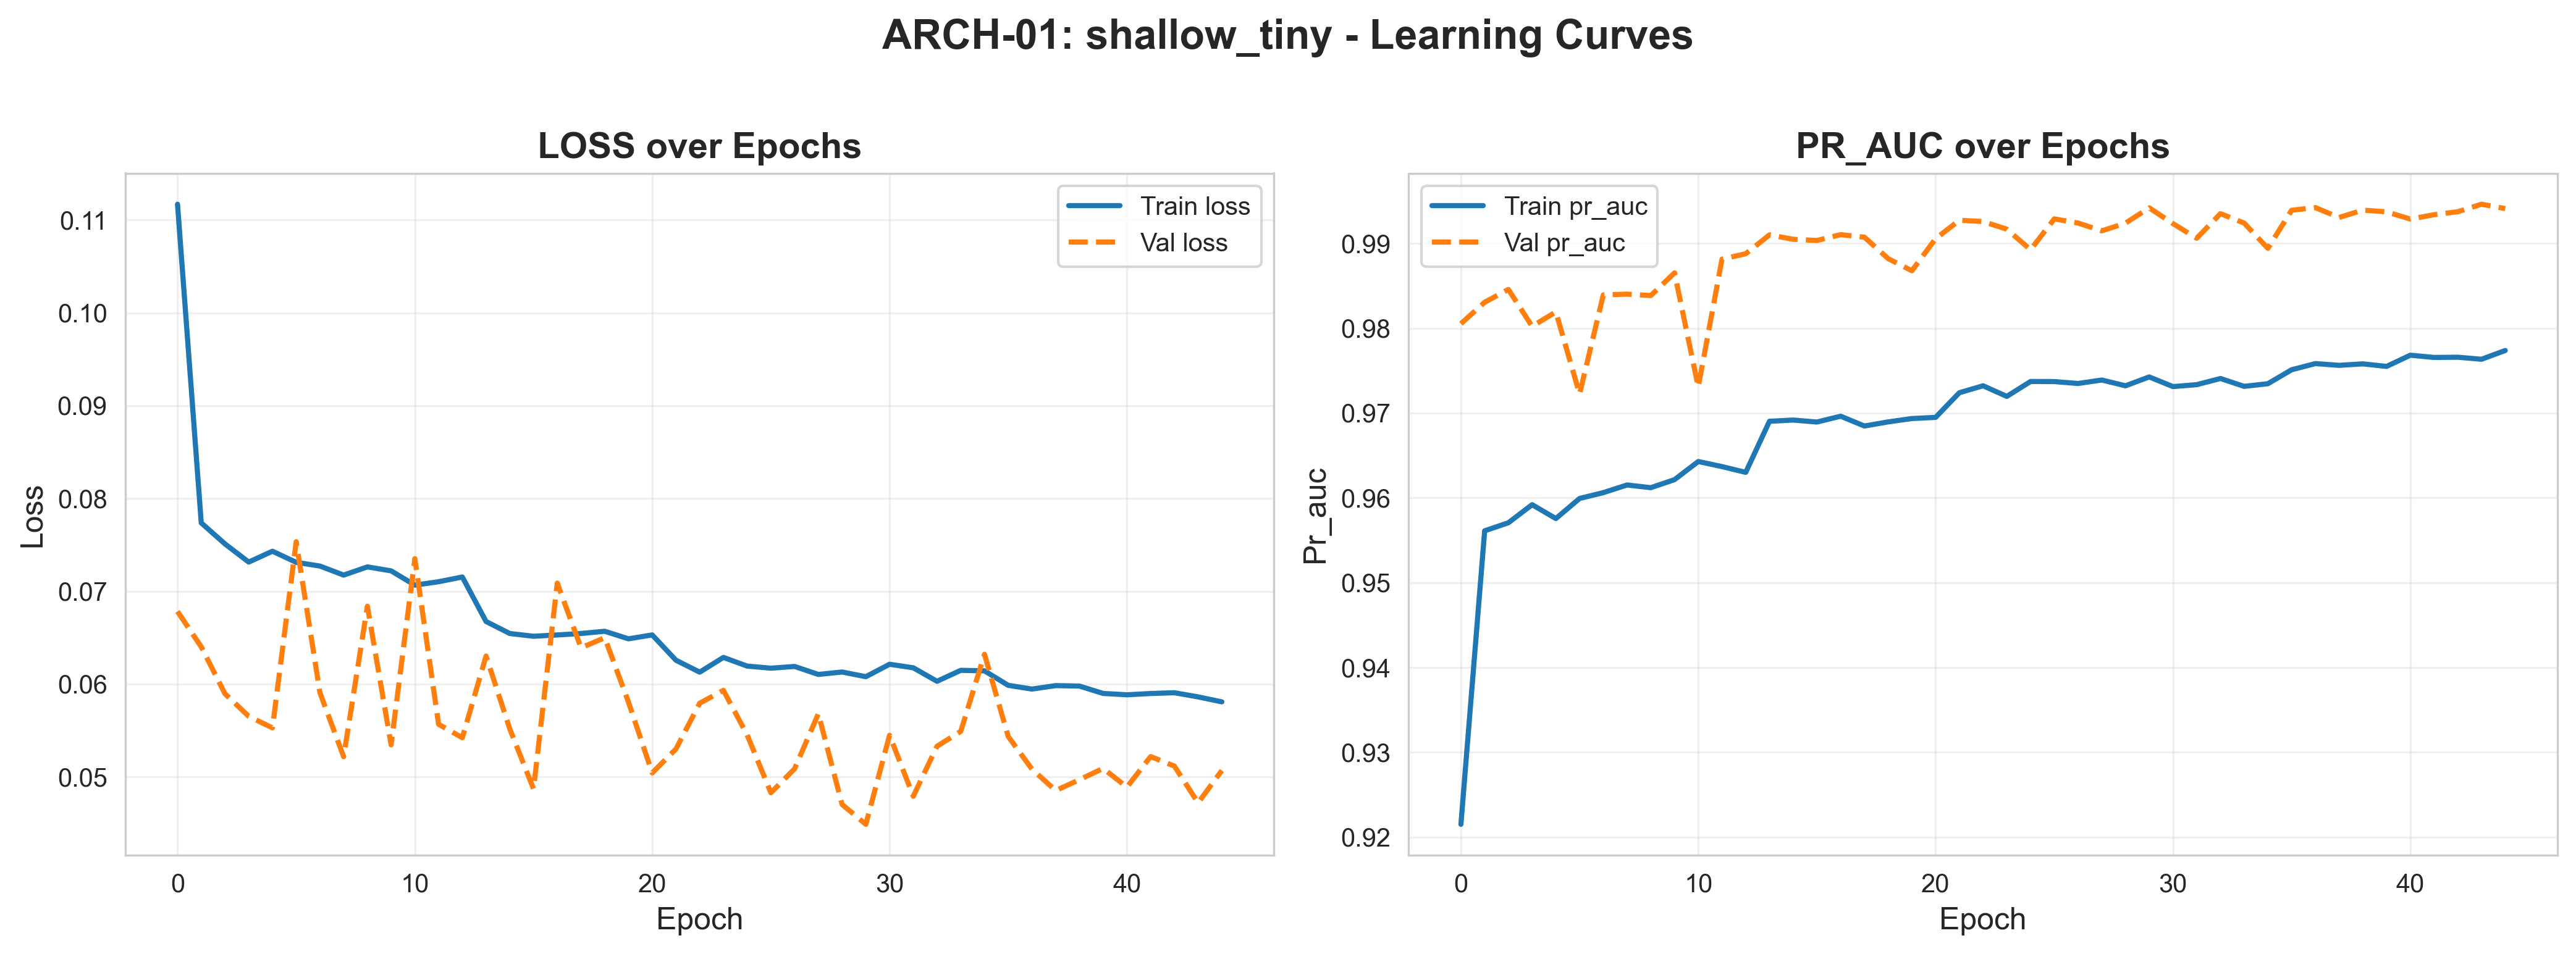

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

Training ARCH-02: shallow_small
Hidden layers: [64, 32]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 34s 3ms/step - loss: 0.1041 - accuracy: 0.9663 - precision: 0.7286 - recall: 0.9799 - auc: 0.9955 - pr_auc: 0.9511 - val_loss: 0.0778 - val_accuracy: 0.9753 - val_precision: 0.7814 - val_recall: 0.9957 - val_auc: 0.9994 - val_pr_auc: 0.9937 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 32s 3ms/step - loss: 0.0633 - accuracy: 0.9803 - precision: 0.8225 - recall: 0.9873 - auc: 0.9979 - pr_auc: 0.9743 - val_loss: 0.0620 - val_accuracy: 0.9813 - val_precision: 0.8261 - val_recall: 0.9963 - val_auc: 0.9994 - val_pr_auc: 0.9939 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 32s 3ms/step - loss: 0.0599 - accuracy: 0.9814 - precision: 0.8311 - recall: 0.9

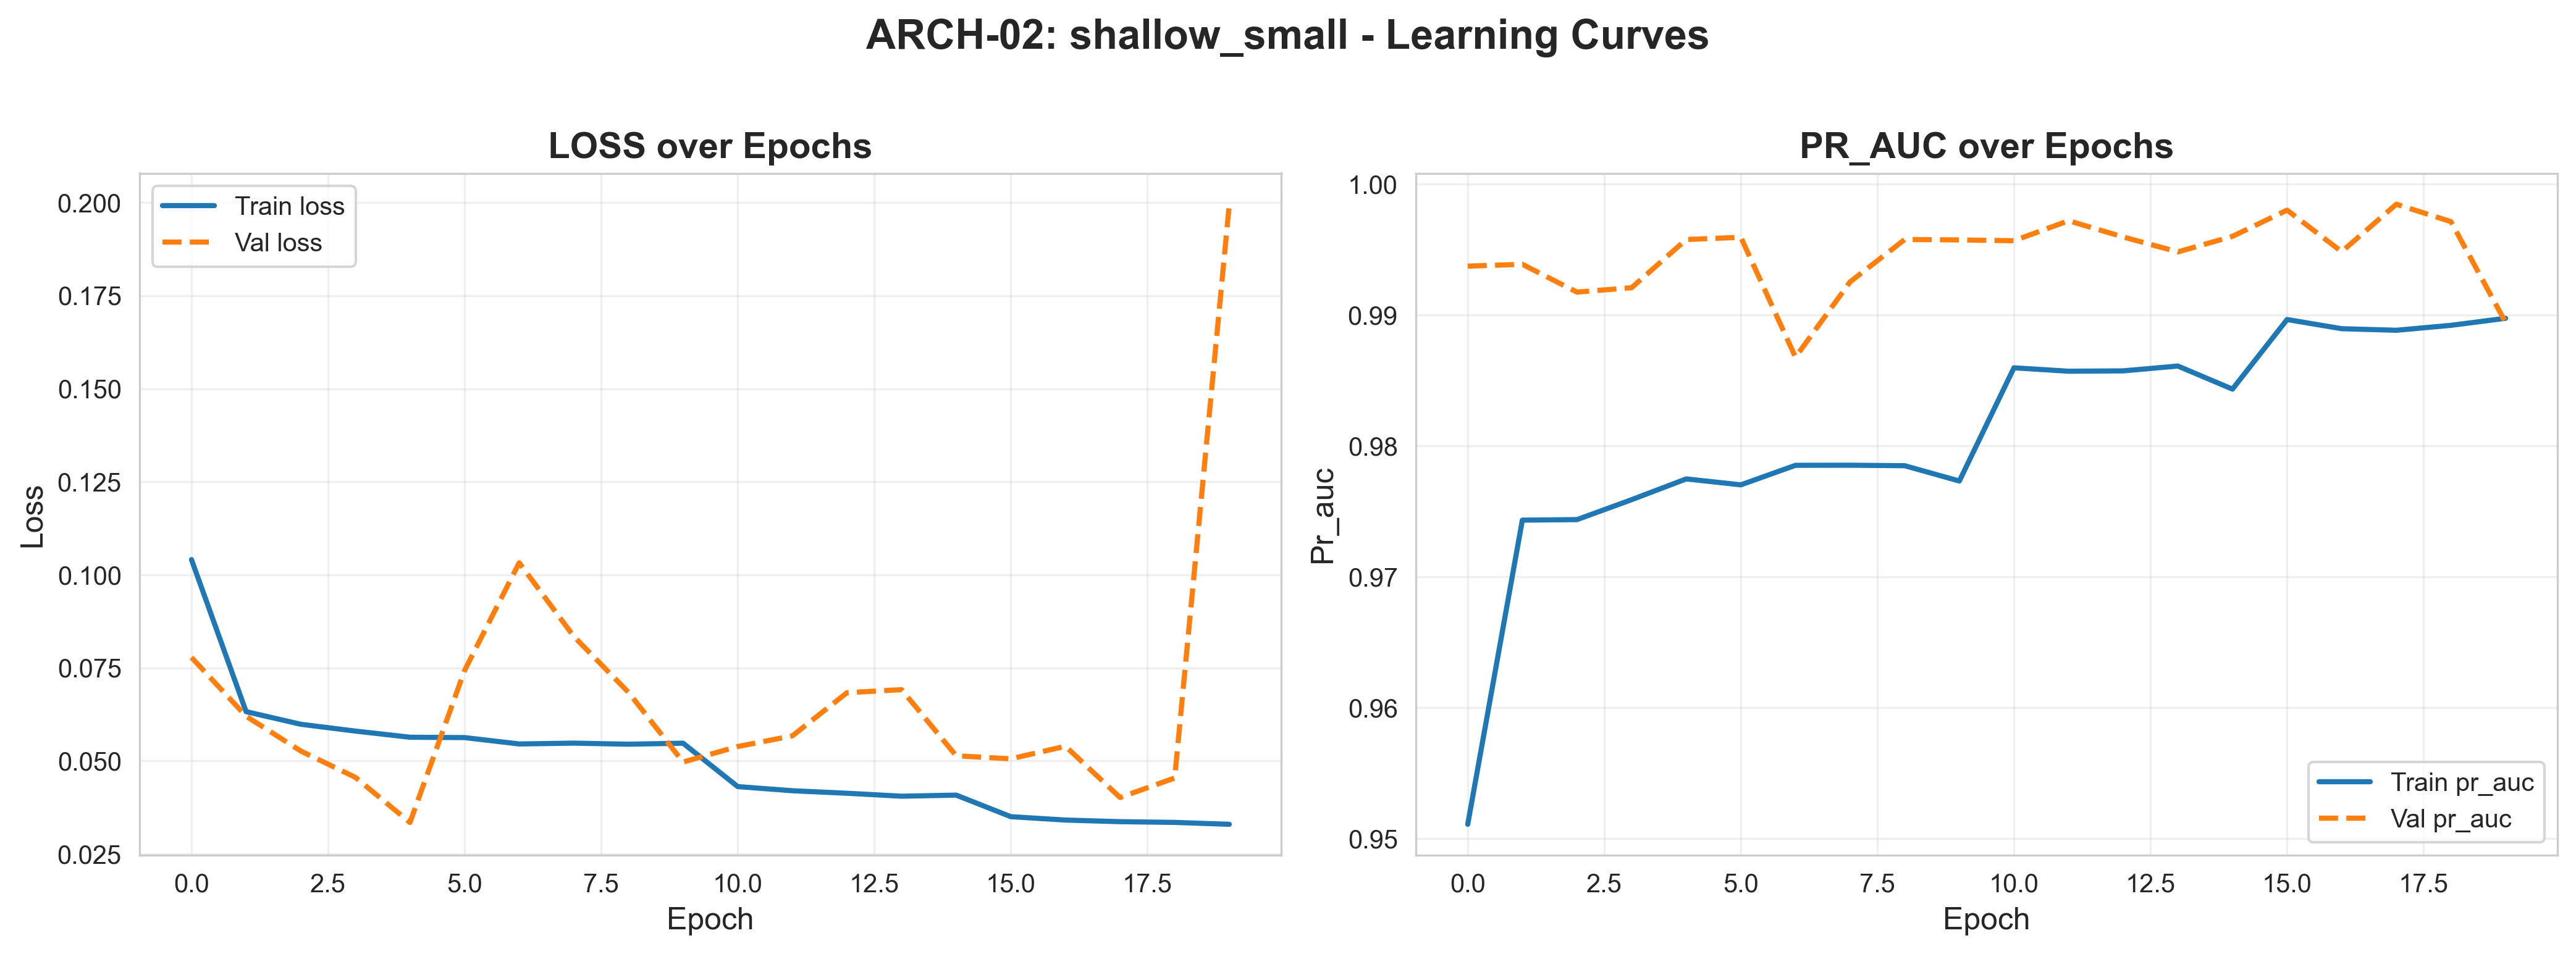

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

Training ARCH-03: medium_base
Hidden layers: [128, 64, 32]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 43s 4ms/step - loss: 0.1280 - accuracy: 0.9683 - precision: 0.7405 - recall: 0.9806 - auc: 0.9955 - pr_auc: 0.9480 - val_loss: 0.0766 - val_accuracy: 0.9813 - val_precision: 0.8260 - val_recall: 0.9951 - val_auc: 0.9990 - val_pr_auc: 0.9907 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 40s 4ms/step - loss: 0.0757 - accuracy: 0.9802 - precision: 0.8214 - recall: 0.9882 - auc: 0.9976 - pr_auc: 0.9705 - val_loss: 0.0740 - val_accuracy: 0.9794 - val_precision: 0.8115 - val_recall: 0.9963 - val_auc: 0.9995 - val_pr_auc: 0.9942 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 39s 4ms/step - loss: 0.0700 - accuracy: 0.9817 - precision: 0.8325 - recall: 

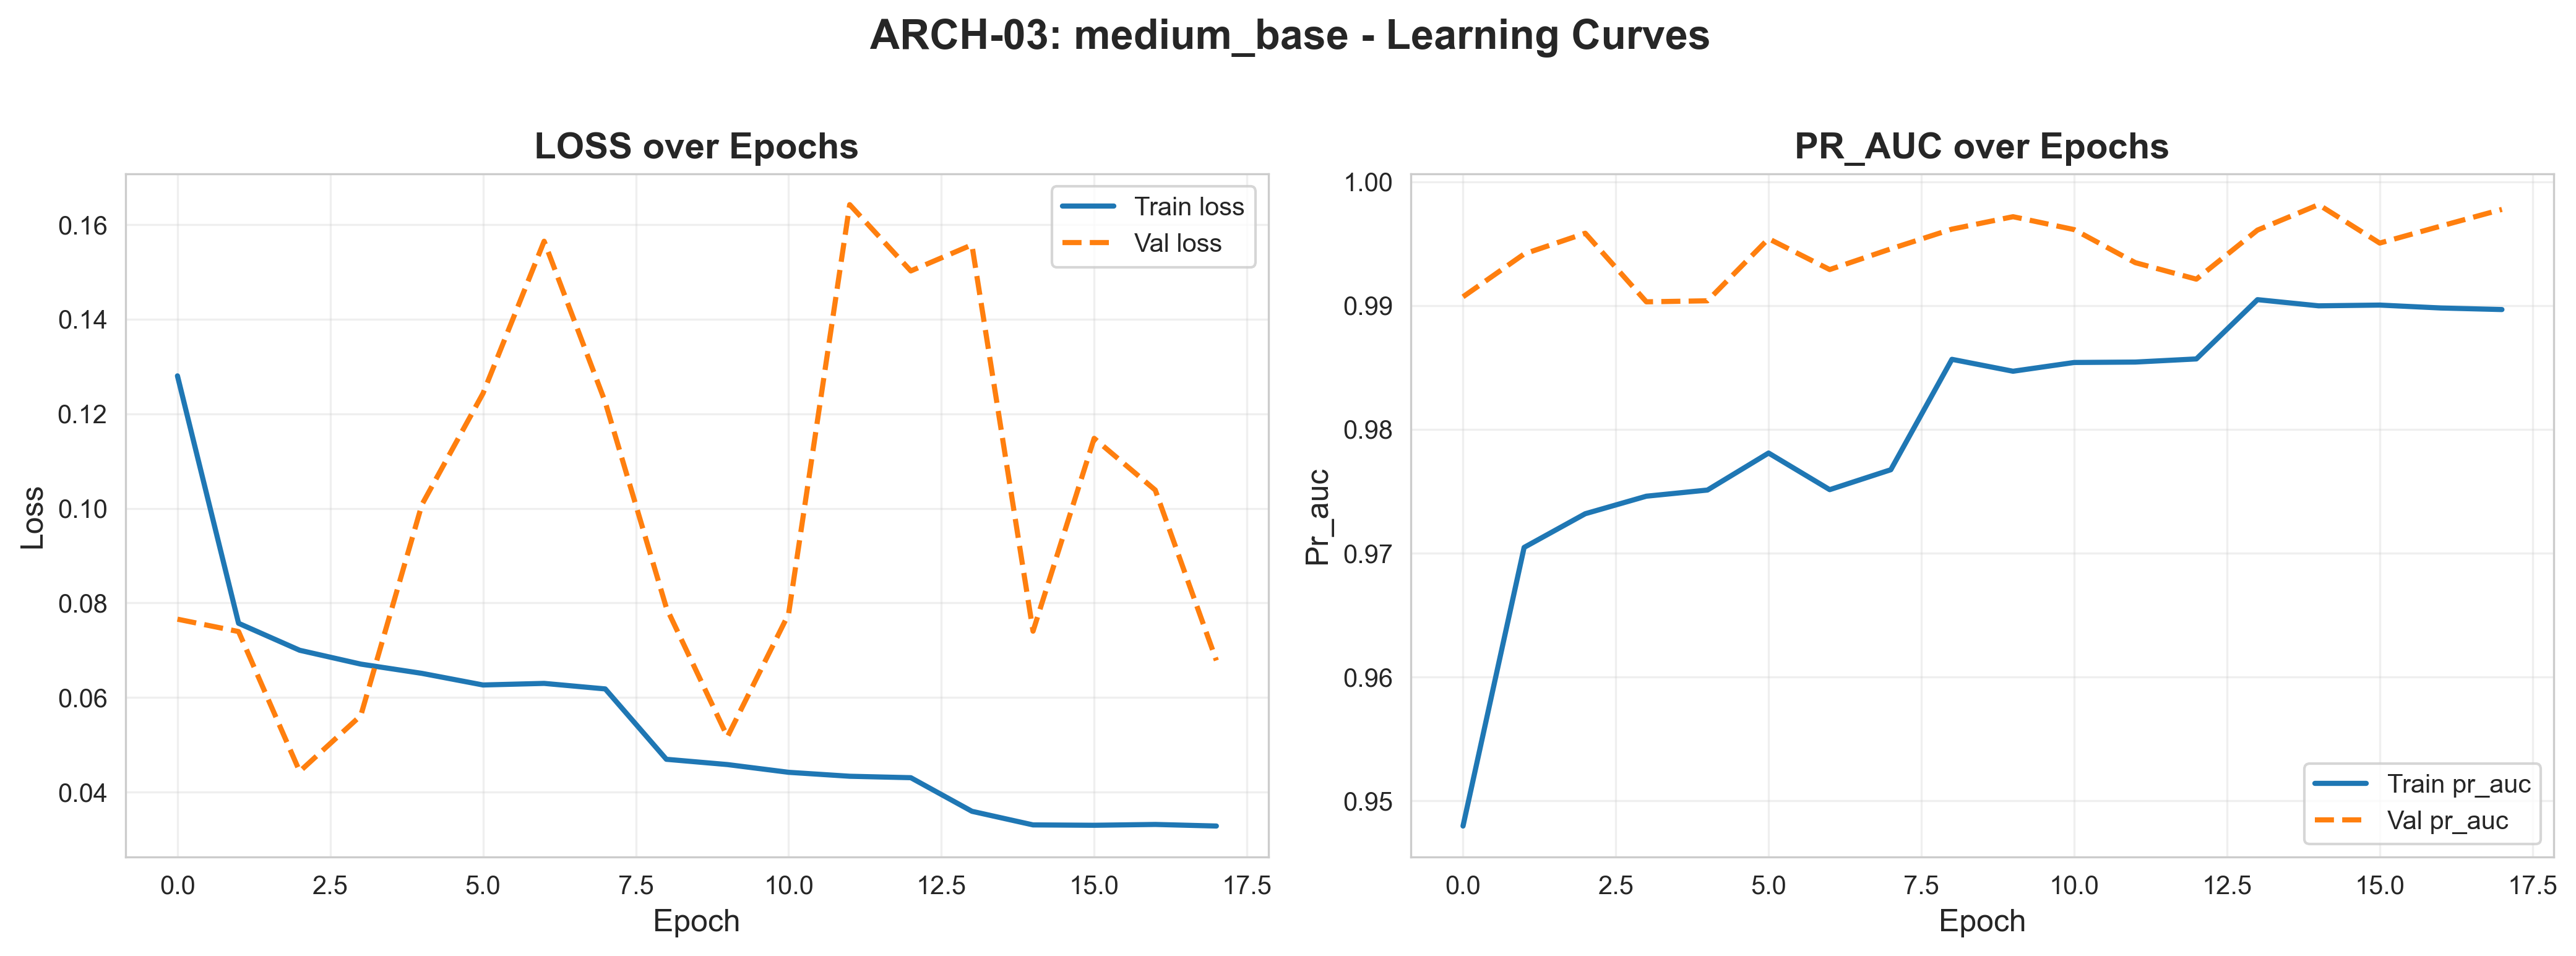

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

Training ARCH-04: medium_deep
Hidden layers: [256, 128, 64, 32]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 56s 5ms/step - loss: 0.1655 - accuracy: 0.9672 - precision: 0.7327 - recall: 0.9826 - auc: 0.9951 - pr_auc: 0.9407 - val_loss: 0.1002 - val_accuracy: 0.9752 - val_precision: 0.7830 - val_recall: 0.9913 - val_auc: 0.9991 - val_pr_auc: 0.9922 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 52s 5ms/step - loss: 0.0964 - accuracy: 0.9776 - precision: 0.8019 - recall: 0.9878 - auc: 0.9970 - pr_auc: 0.9621 - val_loss: 0.0815 - val_accuracy: 0.9802 - val_precision: 0.8184 - val_recall: 0.9944 - val_auc: 0.9993 - val_pr_auc: 0.9943 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 51s 5ms/step - loss: 0.0862 - accuracy: 0.9803 - precision: 0.8221 - rec

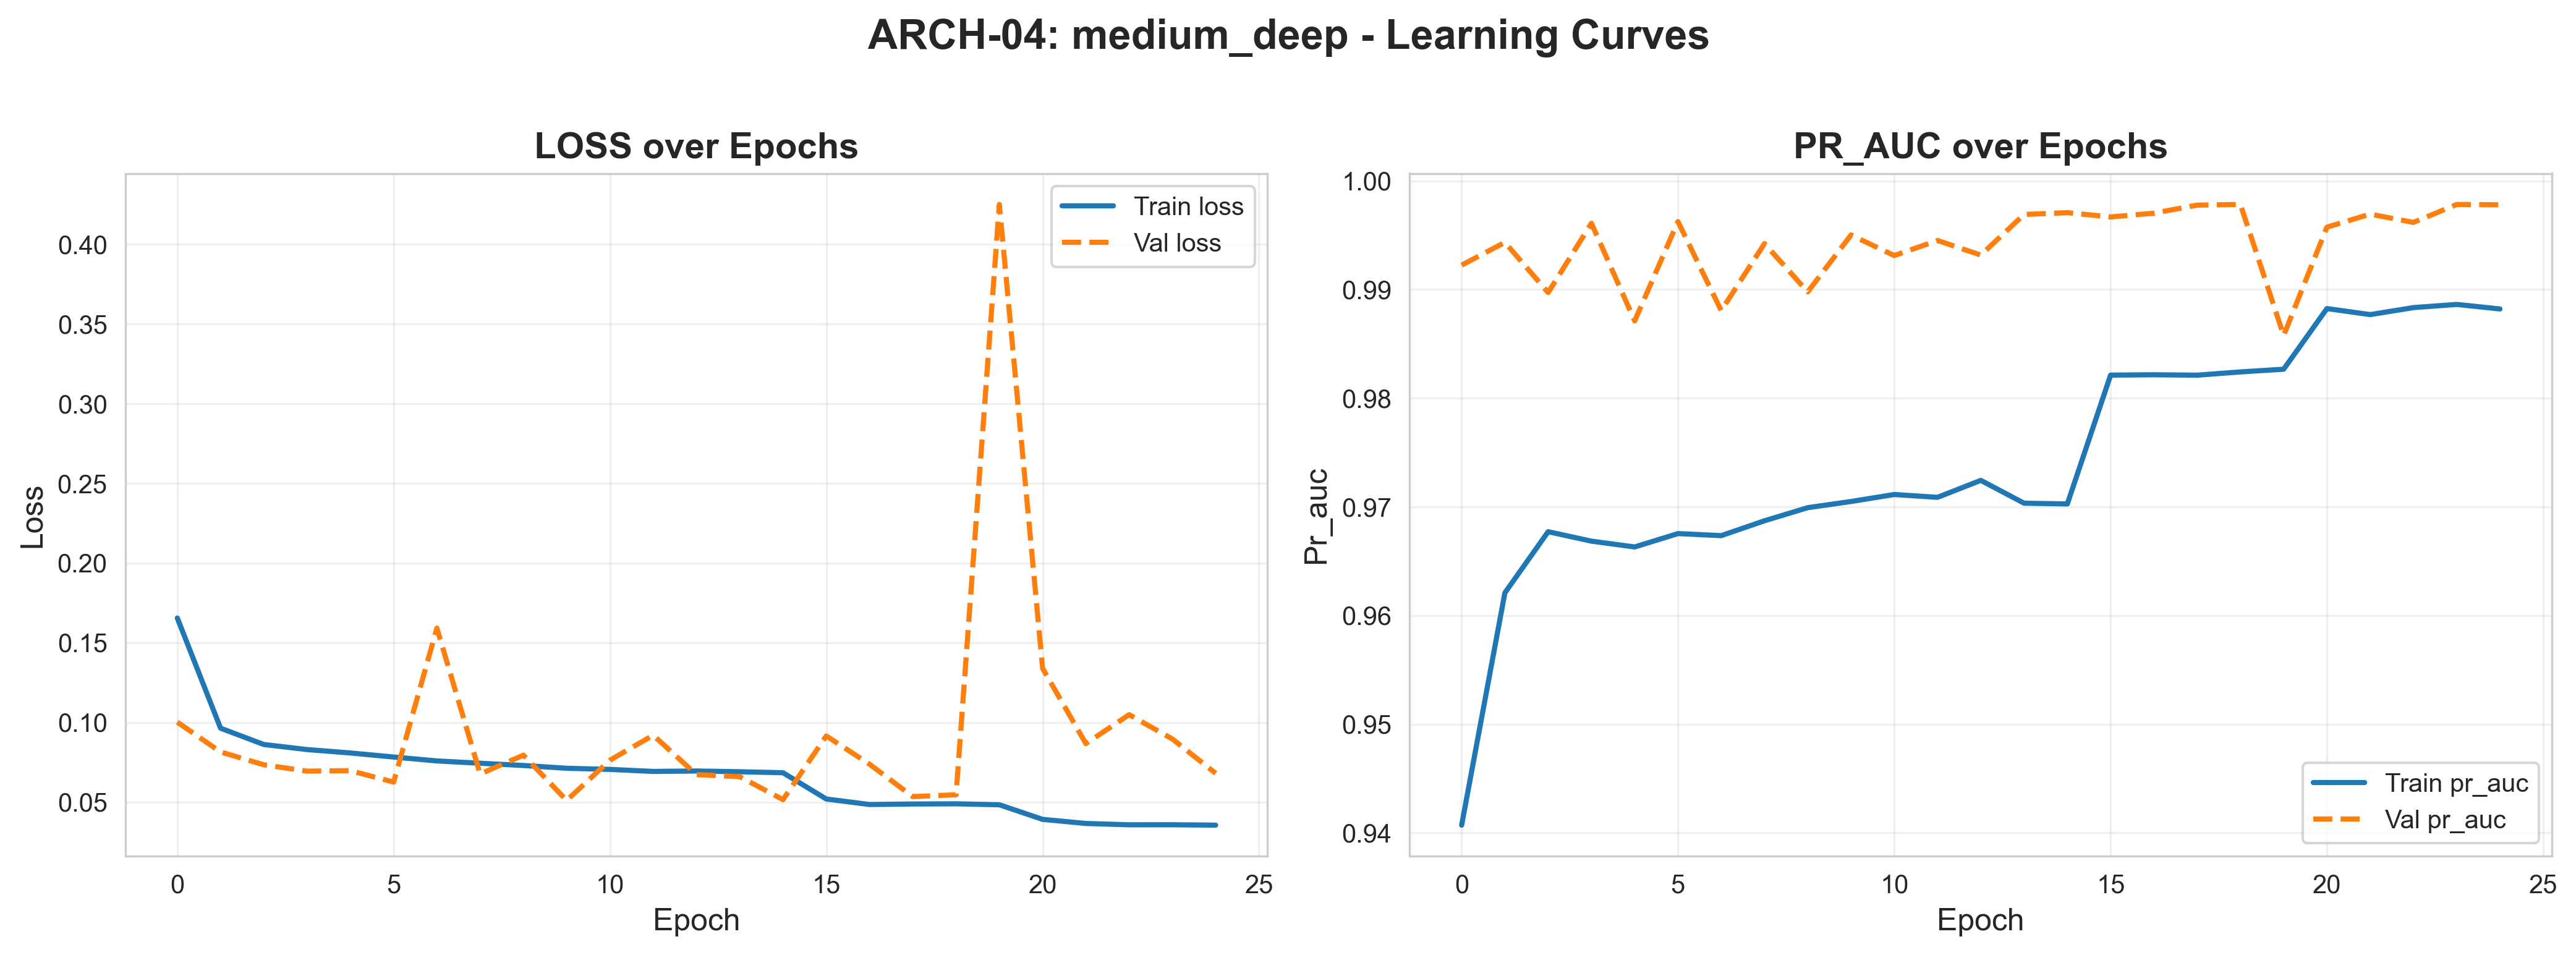

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

Training ARCH-05: deep
Hidden layers: [512, 256, 128, 64, 32, 16]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 83s 7ms/step - loss: 0.2480 - accuracy: 0.9620 - precision: 0.7025 - recall: 0.9795 - auc: 0.9929 - pr_auc: 0.9147 - val_loss: 0.1205 - val_accuracy: 0.9776 - val_precision: 0.8017 - val_recall: 0.9886 - val_auc: 0.9986 - val_pr_auc: 0.9859 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 77s 7ms/step - loss: 0.1391 - accuracy: 0.9744 - precision: 0.7801 - recall: 0.9853 - auc: 0.9956 - pr_auc: 0.9455 - val_loss: 0.1320 - val_accuracy: 0.9713 - val_precision: 0.7549 - val_recall: 0.9940 - val_auc: 0.9977 - val_pr_auc: 0.9841 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 77s 7ms/step - loss: 0.1244 - accuracy: 0.9767 - precision: 0.7959 - r

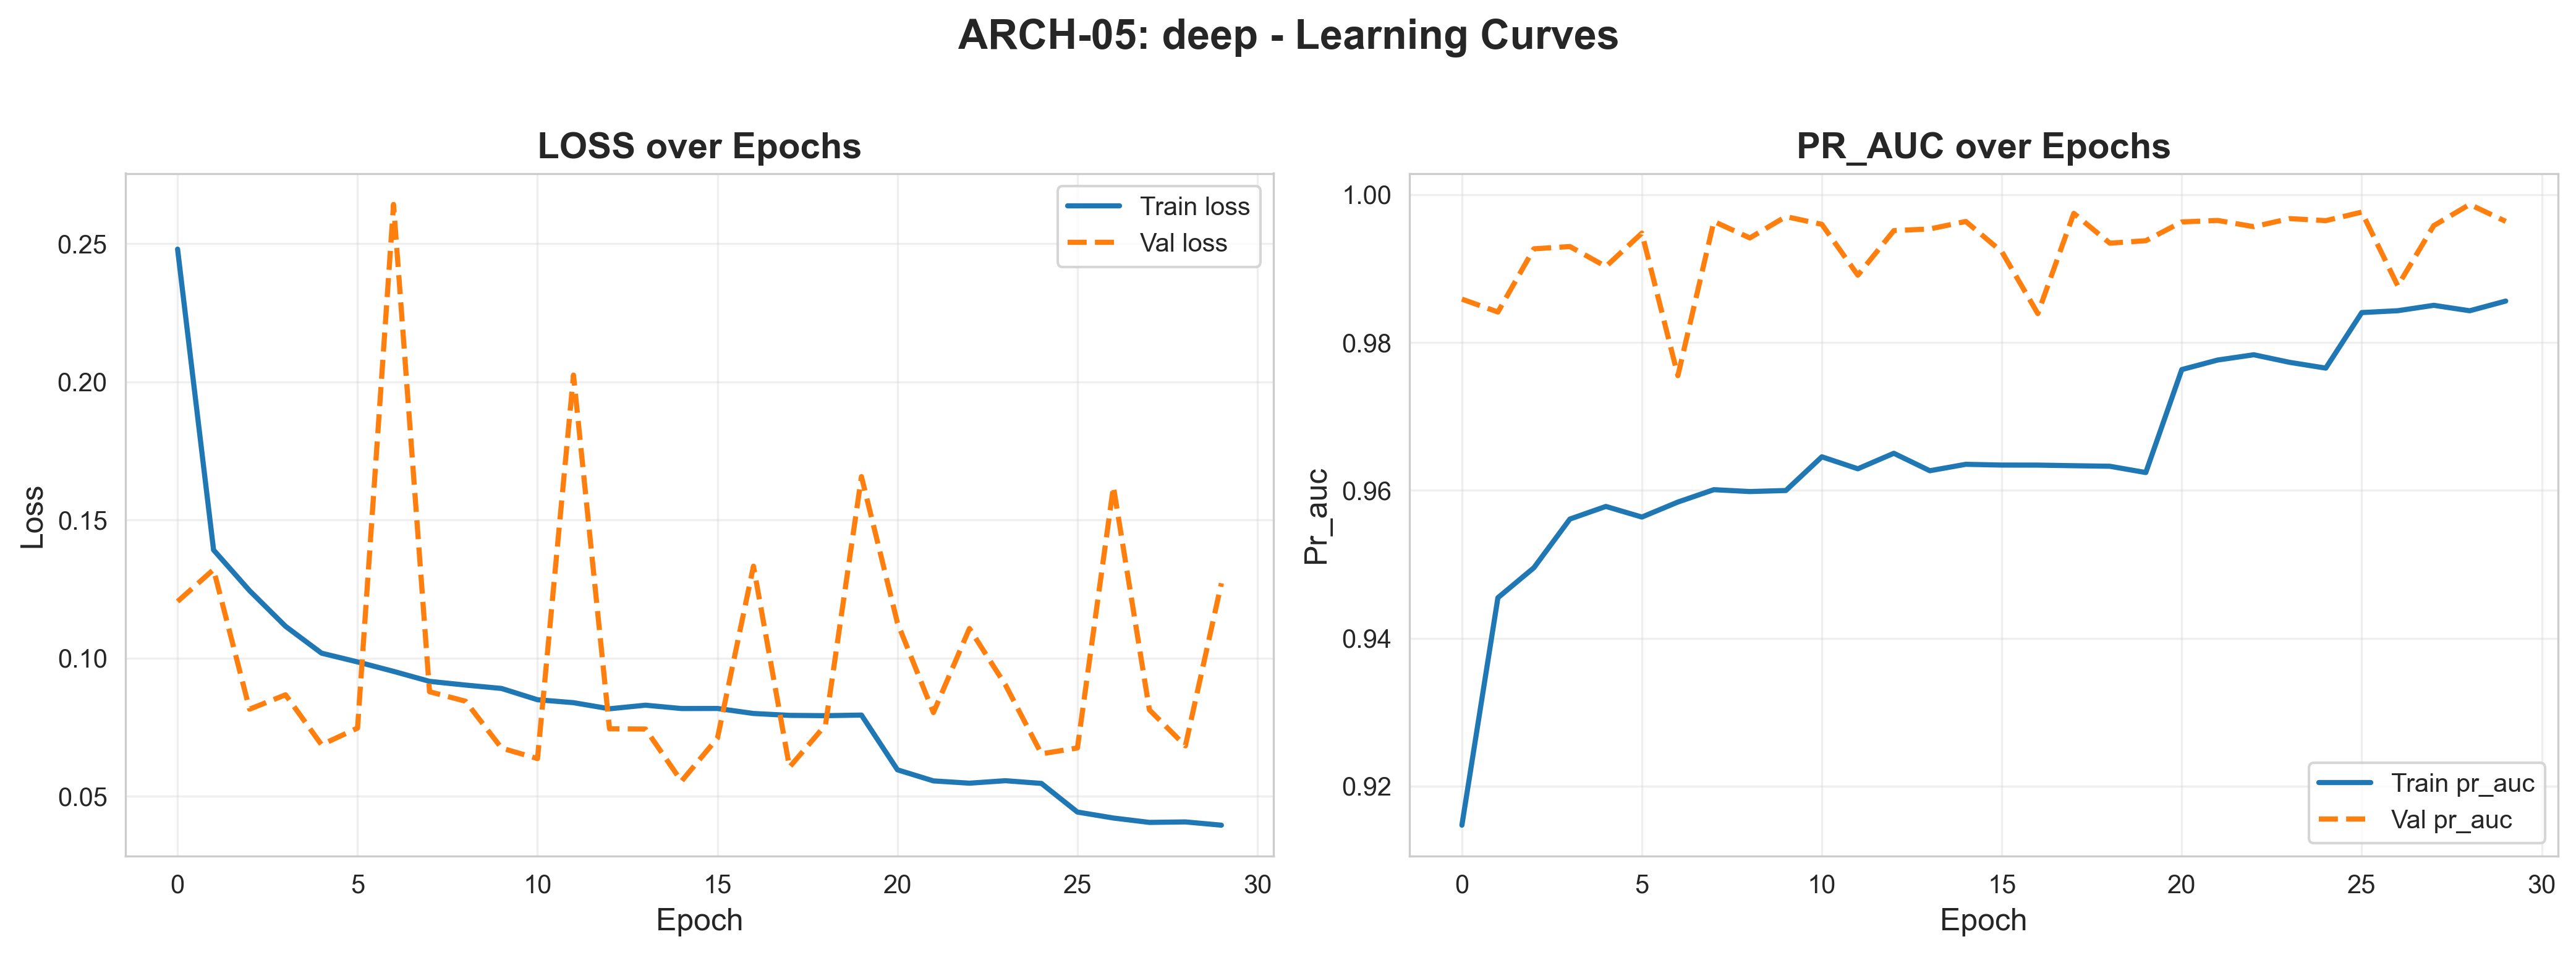

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

Training ARCH-06: wide_medium
Hidden layers: [256]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 30s 3ms/step - loss: 0.0742 - accuracy: 0.9712 - precision: 0.7581 - recall: 0.9853 - auc: 0.9968 - pr_auc: 0.9650 - val_loss: 0.0605 - val_accuracy: 0.9782 - val_precision: 0.8021 - val_recall: 0.9960 - val_auc: 0.9993 - val_pr_auc: 0.9910 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 27s 2ms/step - loss: 0.0581 - accuracy: 0.9782 - precision: 0.8060 - recall: 0.9884 - auc: 0.9979 - pr_auc: 0.9754 - val_loss: 0.0636 - val_accuracy: 0.9796 - val_precision: 0.8128 - val_recall: 0.9963 - val_auc: 0.9989 - val_pr_auc: 0.9848 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 28s 3ms/step - loss: 0.0571 - accuracy: 0.9785 - precision: 0.8078 - recall: 0.9888 -

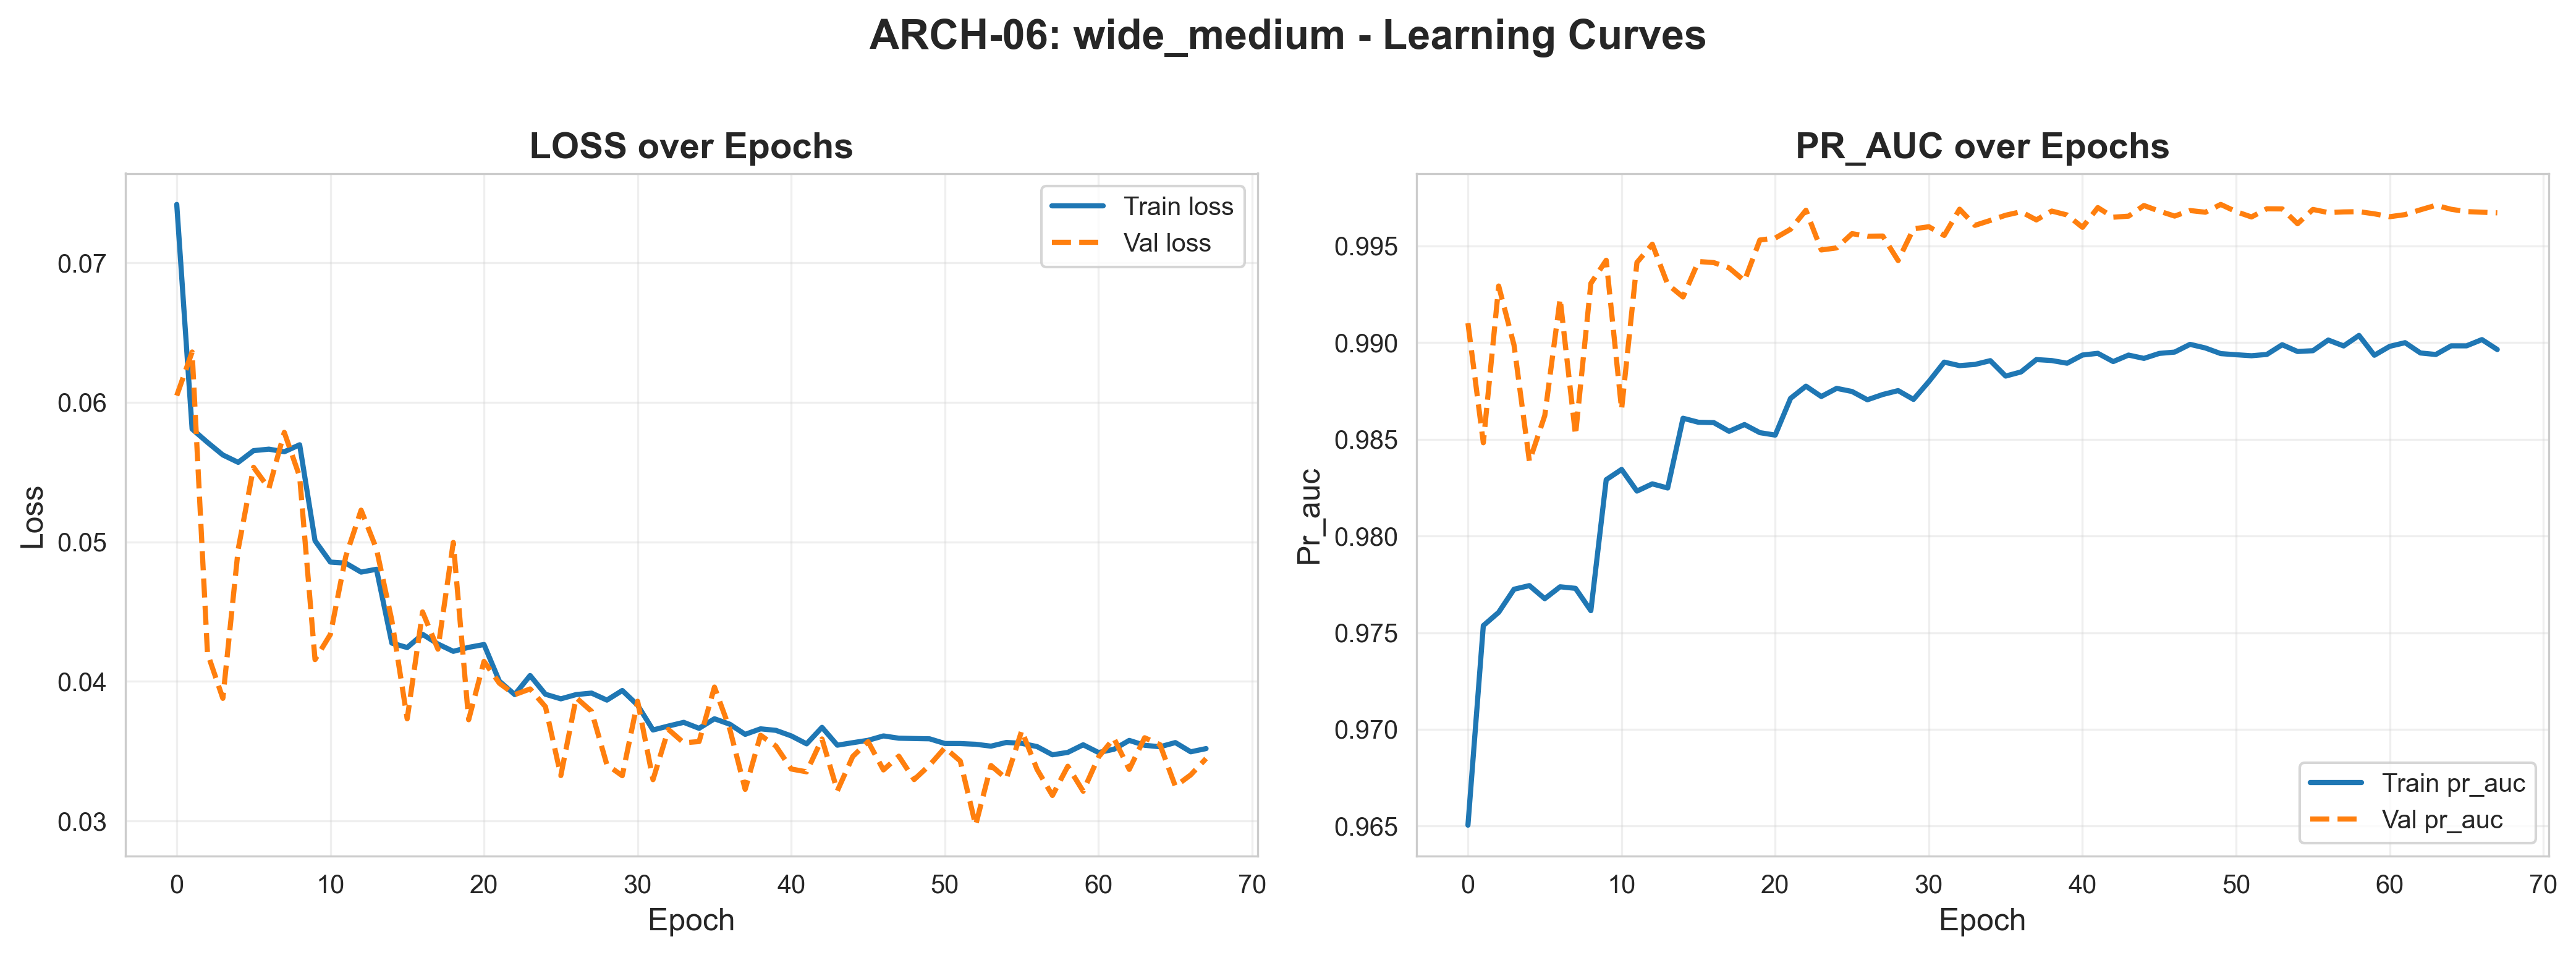

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

Training ARCH-07: wide_large
Hidden layers: [512]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 35s 3ms/step - loss: 0.0717 - accuracy: 0.9748 - precision: 0.7825 - recall: 0.9863 - auc: 0.9972 - pr_auc: 0.9665 - val_loss: 0.0611 - val_accuracy: 0.9818 - val_precision: 0.8292 - val_recall: 0.9974 - val_auc: 0.9991 - val_pr_auc: 0.9854 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 33s 3ms/step - loss: 0.0598 - accuracy: 0.9795 - precision: 0.8161 - recall: 0.9887 - auc: 0.9979 - pr_auc: 0.9752 - val_loss: 0.0599 - val_accuracy: 0.9804 - val_precision: 0.8182 - val_recall: 0.9967 - val_auc: 0.9992 - val_pr_auc: 0.9909 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 33s 3ms/step - loss: 0.0569 - accuracy: 0.9800 - precision: 0.8193 - recall: 0.9889 - 

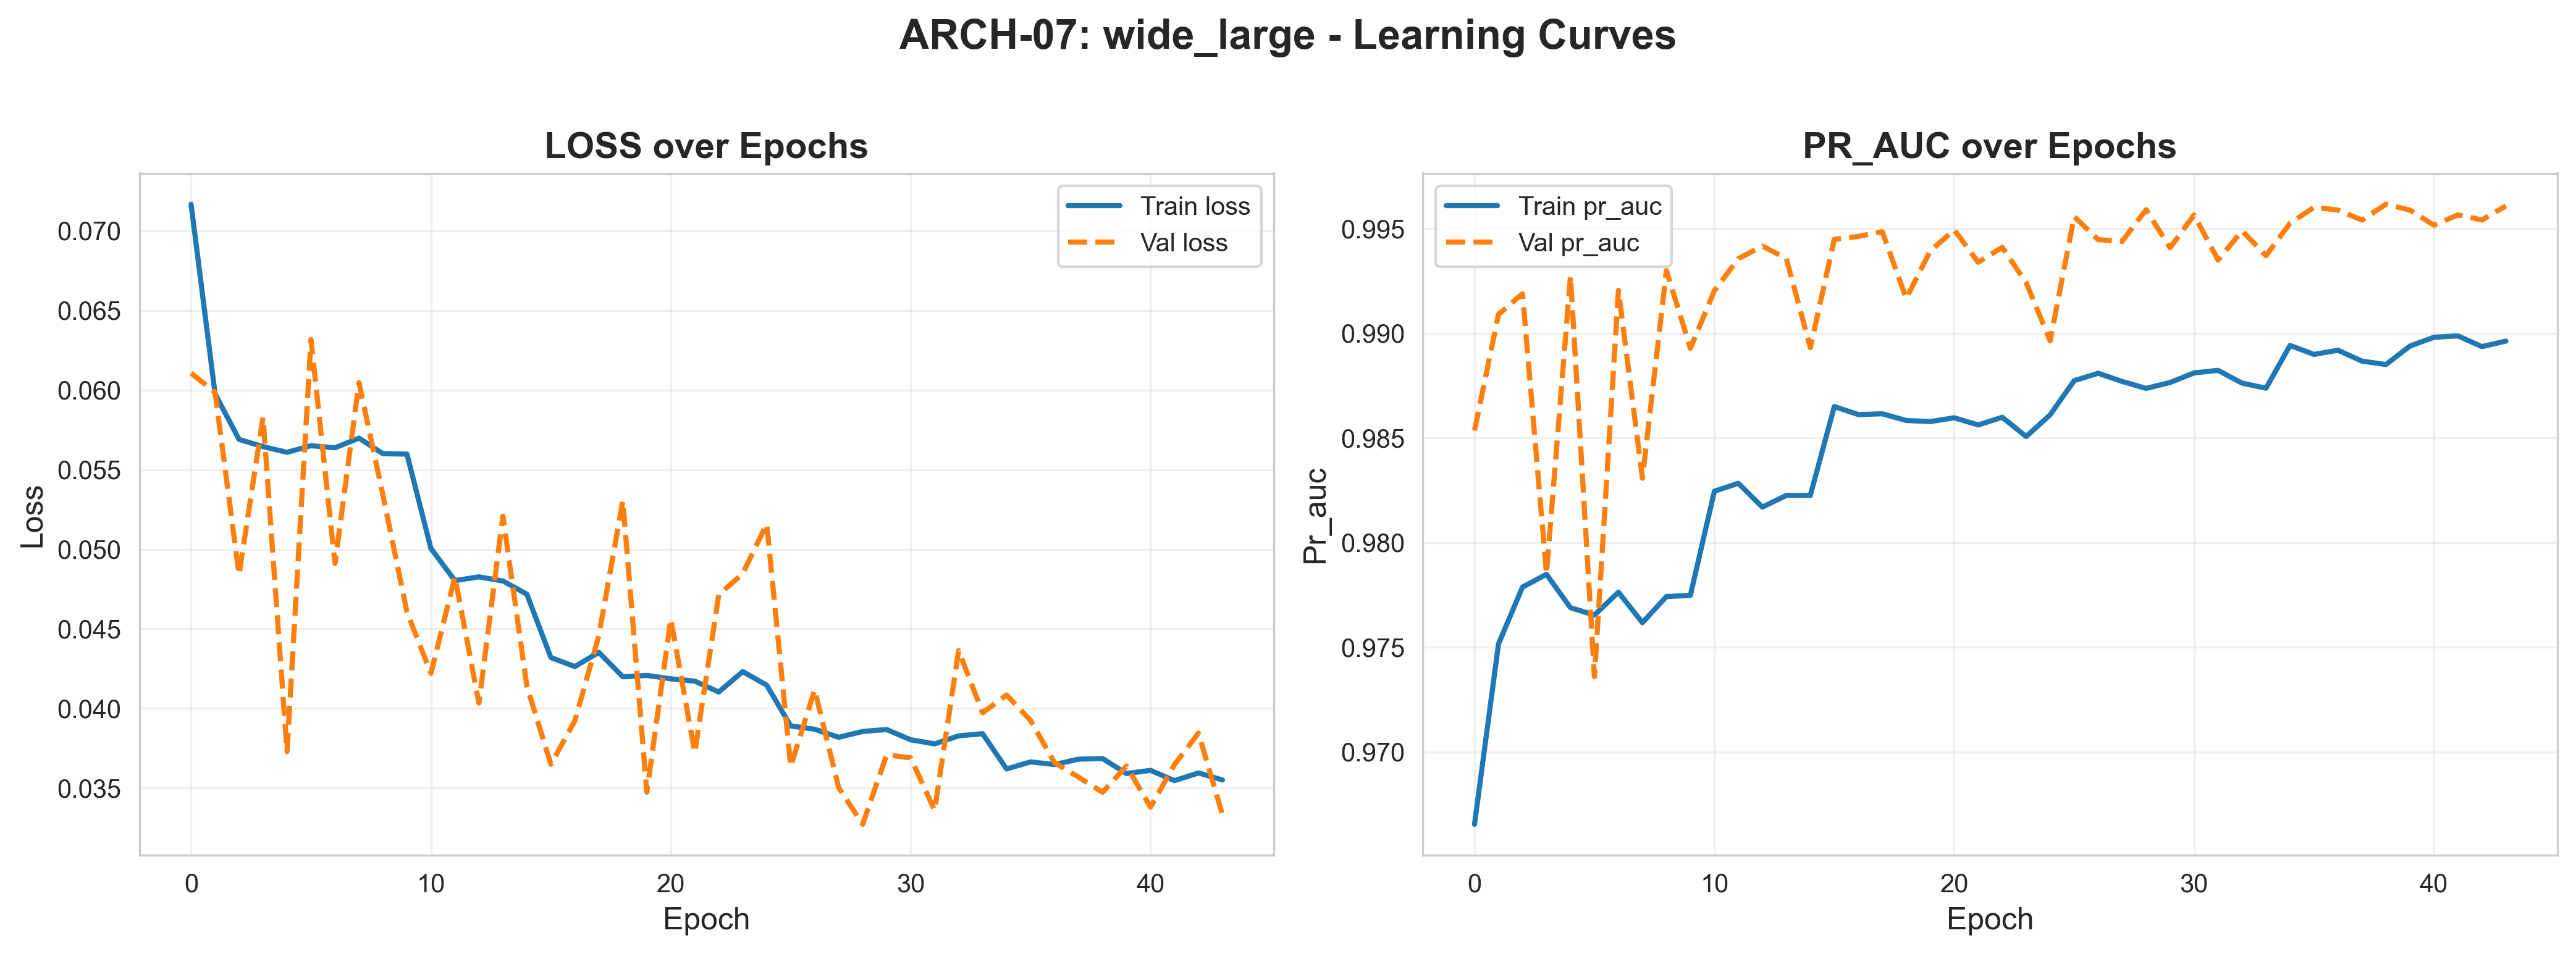

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

Training ARCH-08: balanced
Hidden layers: [256, 128, 64]
Class weights (balanced): {0: 0.5478868785788754, 1: 5.720636788597954}
Epoch 1/100
10938/10938 [==============================] - 47s 4ms/step - loss: 0.1405 - accuracy: 0.9713 - precision: 0.7595 - recall: 0.9834 - auc: 0.9963 - pr_auc: 0.9564 - val_loss: 0.1345 - val_accuracy: 0.9639 - val_precision: 0.7082 - val_recall: 0.9982 - val_auc: 0.9988 - val_pr_auc: 0.9846 - lr: 0.0010
Epoch 2/100
10938/10938 [==============================] - 44s 4ms/step - loss: 0.0846 - accuracy: 0.9803 - precision: 0.8219 - recall: 0.9889 - auc: 0.9976 - pr_auc: 0.9699 - val_loss: 0.0783 - val_accuracy: 0.9824 - val_precision: 0.8346 - val_recall: 0.9956 - val_auc: 0.9994 - val_pr_auc: 0.9932 - lr: 0.0010
Epoch 3/100
10938/10938 [==============================] - 43s 4ms/step - loss: 0.0774 - accuracy: 0.9818 - precision: 0.8337 - recall: 0.

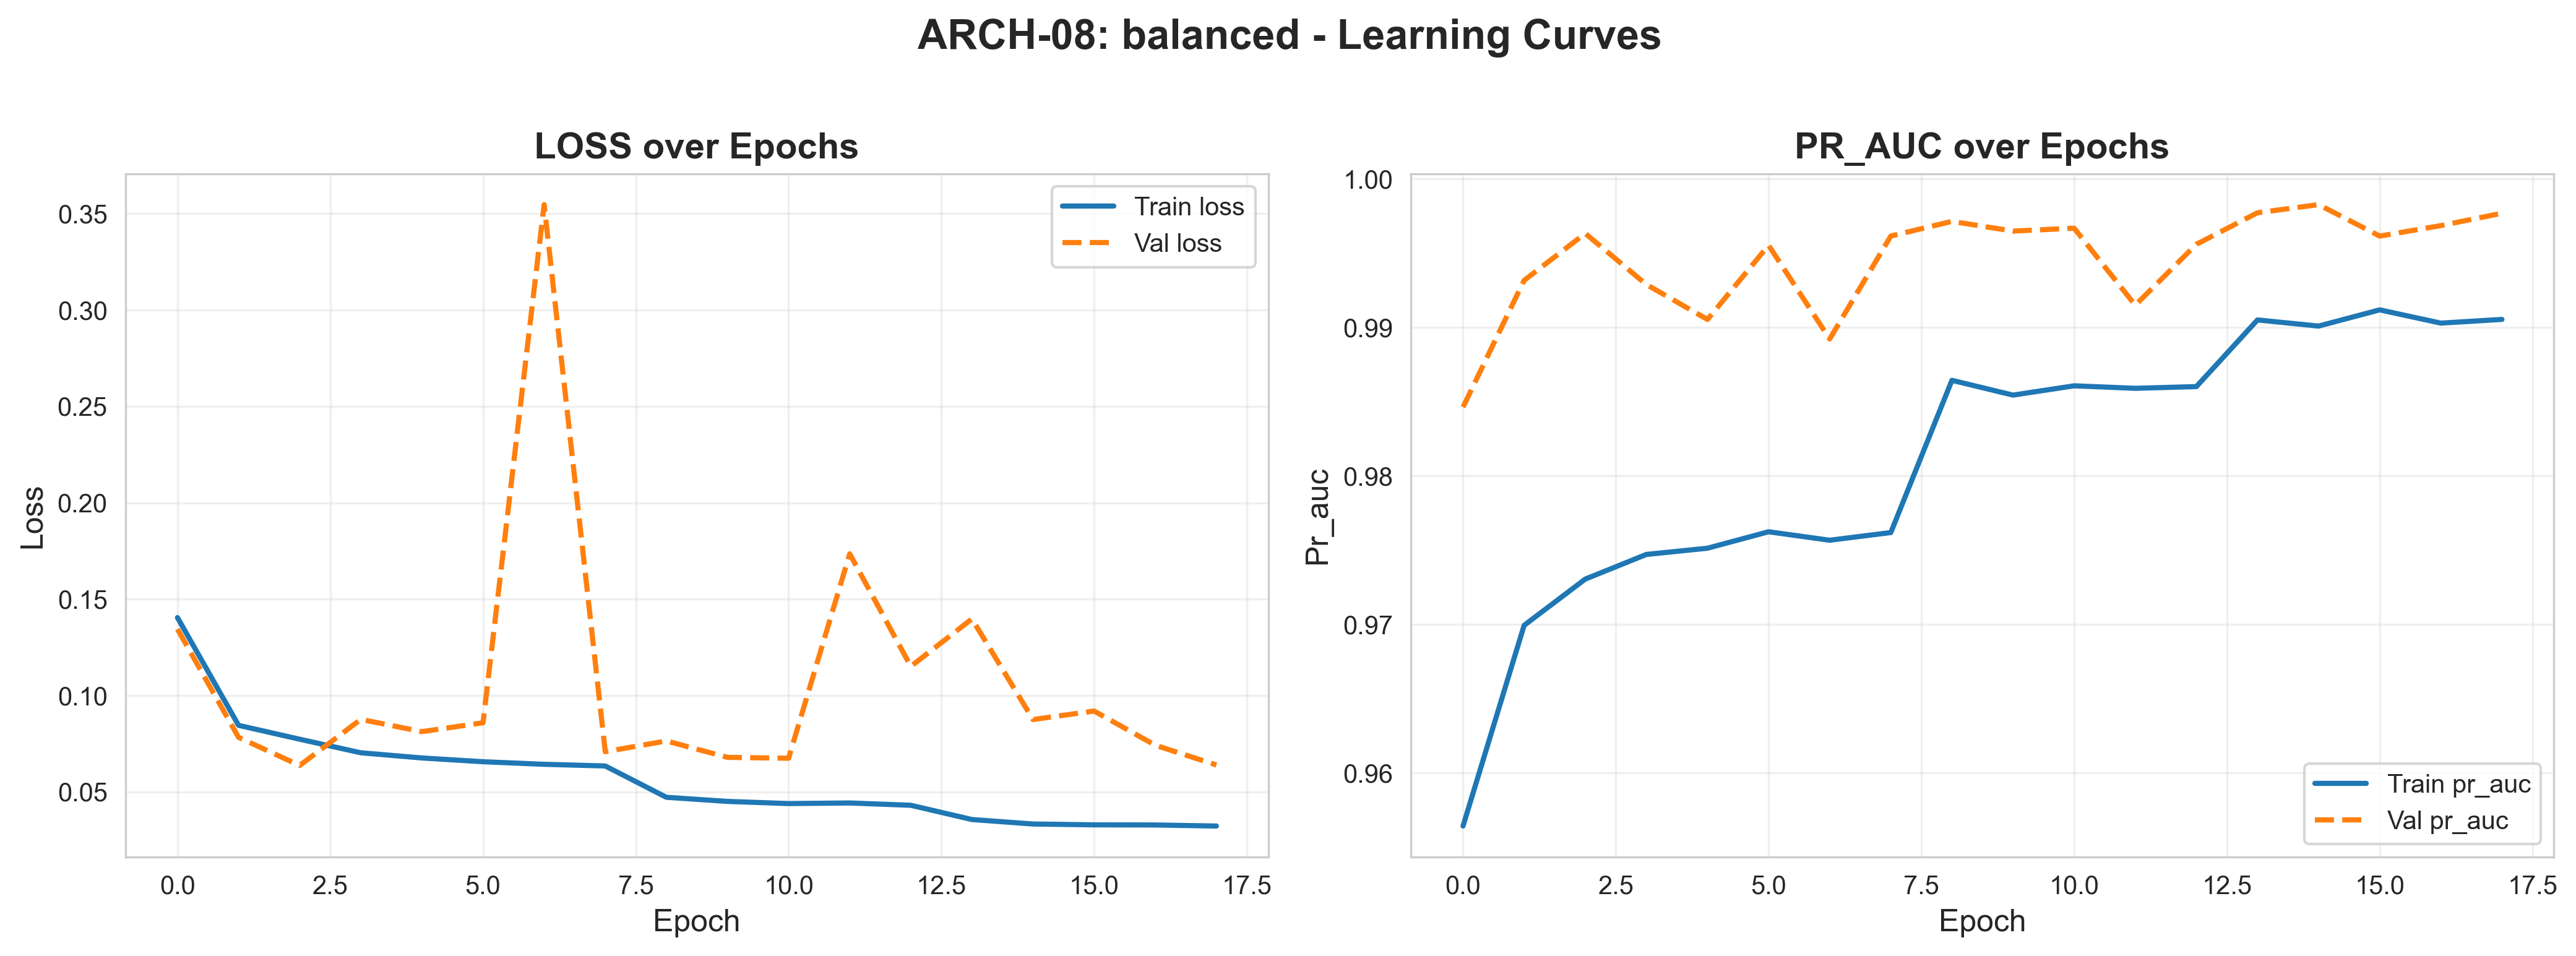

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\logs\nn_experiments.csv

✓ Architecture Search Complete!


In [28]:
# Iterate through architecture configurations
for arch_id, arch_config in config.ARCHITECTURES_TO_TEST.items():
    print(f"\n{'='*70}")
    print(f"Training {arch_id}: {arch_config['name']}")
    print(f"Hidden layers: {arch_config['layers']}")
    print(f"{'='*70}")
    
    # Build model
    model = build_fraud_detection_nn(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=arch_config['layers'],
        dropout_rate=0.3,
        l2_reg=0.001,
        use_batch_norm=True
    )
    
    # Train with early stopping
    history = train_nn_with_early_stopping(
        model=model,
        X_train=X_train_scaled,
        y_train=y_train,
        X_val=X_val_scaled,
        y_val=y_val,
        epochs=config.MAX_EPOCHS,
        batch_size=config.BATCH_SIZE,
        patience=config.EARLY_STOPPING_PATIENCE,
        class_weight='balanced'
    )
    
    # Predictions
    y_val_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    metrics = compute_fraud_metrics(y_val, y_val_pred, y_val_pred_proba)
    
    print(f"\n📊 {arch_id} Validation Performance:")
    print(f"  PR-AUC:        {metrics['pr_auc']:.4f}")
    print(f"  ROC-AUC:       {metrics['roc_auc']:.4f}")
    print(f"  F1 (Fraud):    {metrics['f1_fraud']:.4f}")
    print(f"  Recall (Fraud): {metrics['recall_fraud']:.4f}")
    print(f"  Precision (Fraud): {metrics['precision_fraud']:.4f}")
    
    # Save model
    model_path = ds_config['models_dir'] / 'neural_networks' / f'{arch_id}_{arch_config["name"]}.keras'
    model.save(model_path)
    print(f"\n✓ Model saved to: {model_path}")
    
    # Plot learning curves
    fig_path = ds_config['figures_dir'] / 'nn_architectures' / f'{arch_id}_learning_curves.png'
    fig_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    plot_training_history(
        history,
        save_path=str(fig_path),
        title=f'{arch_id}: {arch_config["name"]} - Learning Curves'
    )
    
    # Log experiment
    experiment_data = {
        'experiment_id': arch_id,
        'dataset': 'card_transdata',
        'experiment_type': 'architecture',
        'model_name': arch_config['name'],
        'architecture': str(arch_config['layers']),
        'dropout': 0.3,
        'l2': 0.001,
        'batch_norm': True,
        'batch_size': config.BATCH_SIZE,
        'epochs_trained': len(history.history['loss']),
        **metrics
    }
    log_experiment(
        experiment_data=experiment_data,
        log_file=str(ds_config['experiment_logs_dir'] / 'nn_experiments.csv')
    )
    
    # Store results
    architecture_results.append({
        'experiment_id': arch_id,
        'architecture': arch_config['name'],
        'layers': str(arch_config['layers']),
        'pr_auc': metrics['pr_auc'],
        'roc_auc': metrics['roc_auc'],
        'f1_fraud': metrics['f1_fraud'],
        'recall_fraud': metrics['recall_fraud'],
        'precision_fraud': metrics['precision_fraud']
    })

print("\n" + "="*70)
print("✓ Architecture Search Complete!")
print("="*70)

## 4. Architecture Comparison

In [29]:
# Check if architecture search completed
if not architecture_results:
    print("⚠️  ERROR: No architecture results found!")
    print("   Please run the architecture search loop (Cell 9) first.")
    raise ValueError("architecture_results is empty - Cell 9 must be executed before this cell")

# Convert results to DataFrame
arch_df = pd.DataFrame(architecture_results)
arch_df = arch_df.sort_values('pr_auc', ascending=False)

print("\n" + "="*80)
print(" ARCHITECTURE RANKING BY PR-AUC (Validation Set)")
print("="*80)
print(arch_df.to_string(index=False))
print("="*80)

# Identify best architecture
best_arch = arch_df.iloc[0]
print(f"\n🏆 Best Architecture: {best_arch['experiment_id']} ({best_arch['architecture']})")
print(f"   Layers: {best_arch['layers']}")
print(f"   PR-AUC: {best_arch['pr_auc']:.4f}")
print(f"   F1 (Fraud): {best_arch['f1_fraud']:.4f}")

# Save ranking
arch_ranking_path = ds_config['tables_dir'] / 'architecture_ranking.csv'
arch_df.to_csv(arch_ranking_path, index=False)
print(f"\n✓ Architecture ranking saved to: {arch_ranking_path}")


 ARCHITECTURE RANKING BY PR-AUC (Validation Set)
experiment_id  architecture                      layers   pr_auc  roc_auc  f1_fraud  recall_fraud  precision_fraud
      ARCH-06   wide_medium                       [256] 0.996573 0.999742  0.932573      0.997941         0.875242
      ARCH-08      balanced              [256, 128, 64] 0.996205 0.999624  0.930674      0.994737         0.874363
      ARCH-07    wide_large                       [512] 0.995338 0.999672  0.930618      0.998475         0.871397
      ARCH-04   medium_deep          [256, 128, 64, 32] 0.994800 0.999154  0.957411      0.989322         0.927494
      ARCH-05          deep [512, 256, 128, 64, 32, 16] 0.993900 0.999504  0.949625      0.994966         0.908236
      ARCH-03   medium_base               [128, 64, 32] 0.993795 0.999644  0.955843      0.994737         0.919876
      ARCH-01  shallow_tiny                        [32] 0.993115 0.999520  0.918484      0.996034         0.852137
      ARCH-02 shallow_small   

## 5. Ablation Study (ABL-01 to ABL-05)

Use best architecture and systematically remove regularization components to isolate their impact.

In [ ]:
# Extract best architecture layers
best_arch_id = best_arch['experiment_id']
best_arch_layers = config.ARCHITECTURES_TO_TEST[best_arch_id]['layers']

print("\n" + "="*70)
print(" ABLATION STUDY: Isolating Regularization Impact")
print("="*70)
print(f"Using best architecture: {best_arch_id} ({best_arch['architecture']})")
print(f"Layers: {best_arch_layers}")
print("="*70)

ablation_results = []

In [ ]:
# Iterate through ablation configurations
for abl_id, abl_config in config.ABLATION_EXPERIMENTS.items():
    print(f"\n{'='*70}")
    print(f"Training {abl_id}: {abl_config['description']}")
    print(f"Dropout={abl_config['dropout']}, L2={abl_config['l2']}, BatchNorm={abl_config['batch_norm']}")
    print(f"{'='*70}")
    
    # Build model with ablation config
    model = build_fraud_detection_nn(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=best_arch_layers,
        dropout_rate=abl_config['dropout'],
        l2_reg=abl_config['l2'],
        use_batch_norm=abl_config['batch_norm']
    )
    
    # Train
    history = train_nn_with_early_stopping(
        model=model,
        X_train=X_train_scaled,
        y_train=y_train,
        X_val=X_val_scaled,
        y_val=y_val,
        epochs=config.MAX_EPOCHS,
        batch_size=config.BATCH_SIZE,
        patience=config.EARLY_STOPPING_PATIENCE,
        class_weight='balanced'
    )
    
    # Predictions
    y_val_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    metrics = compute_fraud_metrics(y_val, y_val_pred, y_val_pred_proba)
    
    print(f"\n📊 {abl_id} Validation Performance:")
    print(f"  PR-AUC:        {metrics['pr_auc']:.4f}")
    print(f"  F1 (Fraud):    {metrics['f1_fraud']:.4f}")
    
    # Save model
    model_path = ds_config['models_dir'] / 'neural_networks' / f'{abl_id}_ablation.keras'
    model.save(model_path)
    
    # Plot learning curves
    fig_path = ds_config['figures_dir'] / 'ablation_studies' / f'{abl_id}_learning_curves.png'
    fig_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    plot_training_history(
        history,
        save_path=str(fig_path),
        title=f'{abl_id}: {abl_config["description"]} - Learning Curves'
    )
    
    # Log experiment
    experiment_data = {
        'experiment_id': abl_id,
        'dataset': 'card_transdata',
        'experiment_type': 'ablation',
        'model_name': f"{best_arch['architecture']}_ablation",
        'architecture': str(best_arch_layers),
        'dropout': abl_config['dropout'],
        'l2': abl_config['l2'],
        'batch_norm': abl_config['batch_norm'],
        'batch_size': config.BATCH_SIZE,
        'epochs_trained': len(history.history['loss']),
        **metrics
    }
    log_experiment(
        experiment_data=experiment_data,
        log_file=str(ds_config['experiment_logs_dir'] / 'nn_experiments.csv')
    )
    
    # Store results
    ablation_results.append({
        'experiment_id': abl_id,
        'description': abl_config['description'],
        'dropout': abl_config['dropout'],
        'l2': abl_config['l2'],
        'batch_norm': abl_config['batch_norm'],
        'pr_auc': metrics['pr_auc'],
        'f1_fraud': metrics['f1_fraud']
    })

print("\n" + "="*70)
print("✓ Ablation Study Complete!")
print("="*70)

## 6. Ablation Analysis

In [ ]:
# Convert results to DataFrame
abl_df = pd.DataFrame(ablation_results)
abl_df = abl_df.sort_values('pr_auc', ascending=False)

print("\n" + "="*90)
print(" ABLATION STUDY RESULTS (Validation Set)")
print("="*90)
print(abl_df.to_string(index=False))
print("="*90)

# Save ablation results
abl_path = ds_config['tables_dir'] / 'ablation_results.csv'
abl_df.to_csv(abl_path, index=False)
print(f"\n✓ Ablation results saved to: {abl_path}")

# Compare with full regularization
full_reg = abl_df[abl_df['experiment_id'] == 'ABL-05'].iloc[0]
no_reg = abl_df[abl_df['experiment_id'] == 'ABL-01'].iloc[0]

print(f"\n📊 Regularization Impact:")
print(f"  No regularization (ABL-01): PR-AUC = {no_reg['pr_auc']:.4f}")
print(f"  Full regularization (ABL-05): PR-AUC = {full_reg['pr_auc']:.4f}")
print(f"  Improvement: {(full_reg['pr_auc'] - no_reg['pr_auc'])*100:.2f} percentage points")

## 7. Summary & Final Recommendations

In [ ]:
print("\n" + "="*70)
print(" NOTEBOOK 03 SUMMARY - card_transdata NN ARCHITECTURE & ABLATION")
print("="*70)

print(f"\n🏆 Best Architecture: {best_arch['experiment_id']} - {best_arch['architecture']}")
print(f"   Layers: {best_arch['layers']}")
print(f"   Validation PR-AUC: {best_arch['pr_auc']:.4f}")

print(f"\n📊 Baseline Comparison:")
print(f"   Random Forest: {rf_pr_auc:.4f}")
print(f"   Best NN:       {best_arch['pr_auc']:.4f}")
print(f"   Difference:    {(best_arch['pr_auc'] - rf_pr_auc)*100:+.2f} percentage points")

if best_arch['pr_auc'] < rf_pr_auc:
    print("\n✅ Expected Result: RF outperforms NN on synthetic data")
    print("   This does NOT invalidate the NN experiments:")
    print("   - Clean architecture exploration completed")
    print("   - Ablation insights gained")
    print("   - Design principles transferable to creditcard.csv")

print(f"\n🔬 Ablation Insights:")
print(f"   No regularization:   PR-AUC = {no_reg['pr_auc']:.4f}")
print(f"   Full regularization: PR-AUC = {full_reg['pr_auc']:.4f}")
print(f"   Regularization value: {(full_reg['pr_auc'] - no_reg['pr_auc'])*100:+.2f}pp")

print(f"\n🚀 Next Steps:")
print(f"   1. Transfer best architecture to creditcard.csv (Notebook 04-06)")
print(f"   2. Validate on real-world ULB dataset")
print(f"   3. Test regularization strategies (REG-01 to REG-08)")
print(f"   4. Compare NN vs. RF on production-quality data")

print("\n📁 Artifacts Created:")
print(f"   - {len(architecture_results)} architecture models")
print(f"   - {len(ablation_results)} ablation models")
print(f"   - Experiment logs: {ds_config['experiment_logs_dir']}/nn_experiments.csv")
print(f"   - Learning curves: {ds_config['figures_dir']}/")
print(f"   - Rankings: {ds_config['tables_dir']}/")

print("\n✅ Notebook 03 Complete!")
print("🎯 Ready for Notebook 04: creditcard preprocessing & baselines")
print("="*70)